# Part 2. Anomaly Detection

Now, we will work with anomaly detection problem. In this example, we will take a look at the **Credit Card Fraud Detection** dataset, which is recently one of the most interesting business problem that we're trying to solve using Machine Learning algorithms.

Today, we will work on this problem using **Gaussian Mixture Models** approach, which is trained in unsupervised fashion. As you'll see in a while, our dataset contains information about assigned class (regular transaction or fraud) but we won't use it in our algorithm. In the real life scenario, we would face very similar case. Imagine that you're an engineer that has access to all users' bank account history, including his/her problem notifications about potential fraud.

As you could've ever experienced, such fraud detection algorithms are already used by banks across the globe. Have you ever received an information that your card is blocked because you've tried to buy something expensive or do shopping outside of your country? Probably yes!

![Credit Card](assets/credit_card_dataset.jpg)

## 1. Import everything we need

As usual, let's import all libraries that we will use in this notebook.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn.mixture import GaussianMixture

## 2. Understand our dataset

This step is very crucial! Let's check what data we've got and which of them may be useful for the purpose of this analysis.

In [2]:
TRANSACTIONS_DATASET = './datasets/creditcard.csv'
transactions = pd.read_csv(TRANSACTIONS_DATASET)
transactions.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


As you can see, we've got almost **28 anonymised features** that may contain some interesting information. Also, we've got `Time` column, which describes time related to the first dumped entry. At the end, you can find `Amount` column, which as you might guess, tells us what was the amount of money spent on given transaction.

The last column is very important, it is `Class`. It tells us if a given transaction is marked as regular transaction (Class == 0) or fraud transaction (Class == 1).

NOTE: In this notebook, we will focus only on these anonymised features and won't take into consideration the amount of money nor time at which given transaction was made.

In [3]:
REGULAR_TRANSACTION = 0
FRAUD_TRANSACTION = 1

We can also check some basic statistics for this dataset using Pandas' `.describe()` method.

In [4]:
transactions.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.165980e-15,3.416908e-16,-1.373150e-15,2.086869e-15,9.604066e-16,1.490107e-15,-5.556467e-16,1.177556e-16,-2.406455e-15,...,1.656562e-16,-3.444850e-16,2.578648e-16,4.471968e-15,5.340915e-16,1.687098e-15,-3.666453e-16,-1.220404e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


Before choosing an algorithm that we would like to use in order to solve anomaly detection problem, it is very important to check how many examples are marked as anomalies. Sometimes, when the dataset is balanced, we may choose Supervised Learning algorithms like Neural Networks, Support Vector Machines and others.

In [5]:
number_of_transactions = len(transactions)
number_of_regular_transactions = len(transactions[transactions['Class'] == REGULAR_TRANSACTION])
number_of_fraud_transactions = len(transactions[transactions['Class'] == FRAUD_TRANSACTION])
print('Number of Regular Transactions: {} ({:.4f}%)'.format(
    number_of_regular_transactions, number_of_regular_transactions / number_of_transactions))
print('Number of Fraud Transactions: {} ({:.4f}%)'.format(
    number_of_fraud_transactions, number_of_fraud_transactions / number_of_transactions))

Number of Regular Transactions: 284315 (0.9983%)
Number of Fraud Transactions: 492 (0.0017%)


And, as it is described above, we've got **very unbalanced dataset**! Only 0.0017% of our dataset was marked as abnormal, so it's a perfect case for Unsupervised Learning approach. Supervised Learning methods would overfit to the regular examples and wouldn't be able to detect all possible anomalies that could be found in the real life.

Before we start the training, let's check how does the data distribution looks like for our anonimised featues.

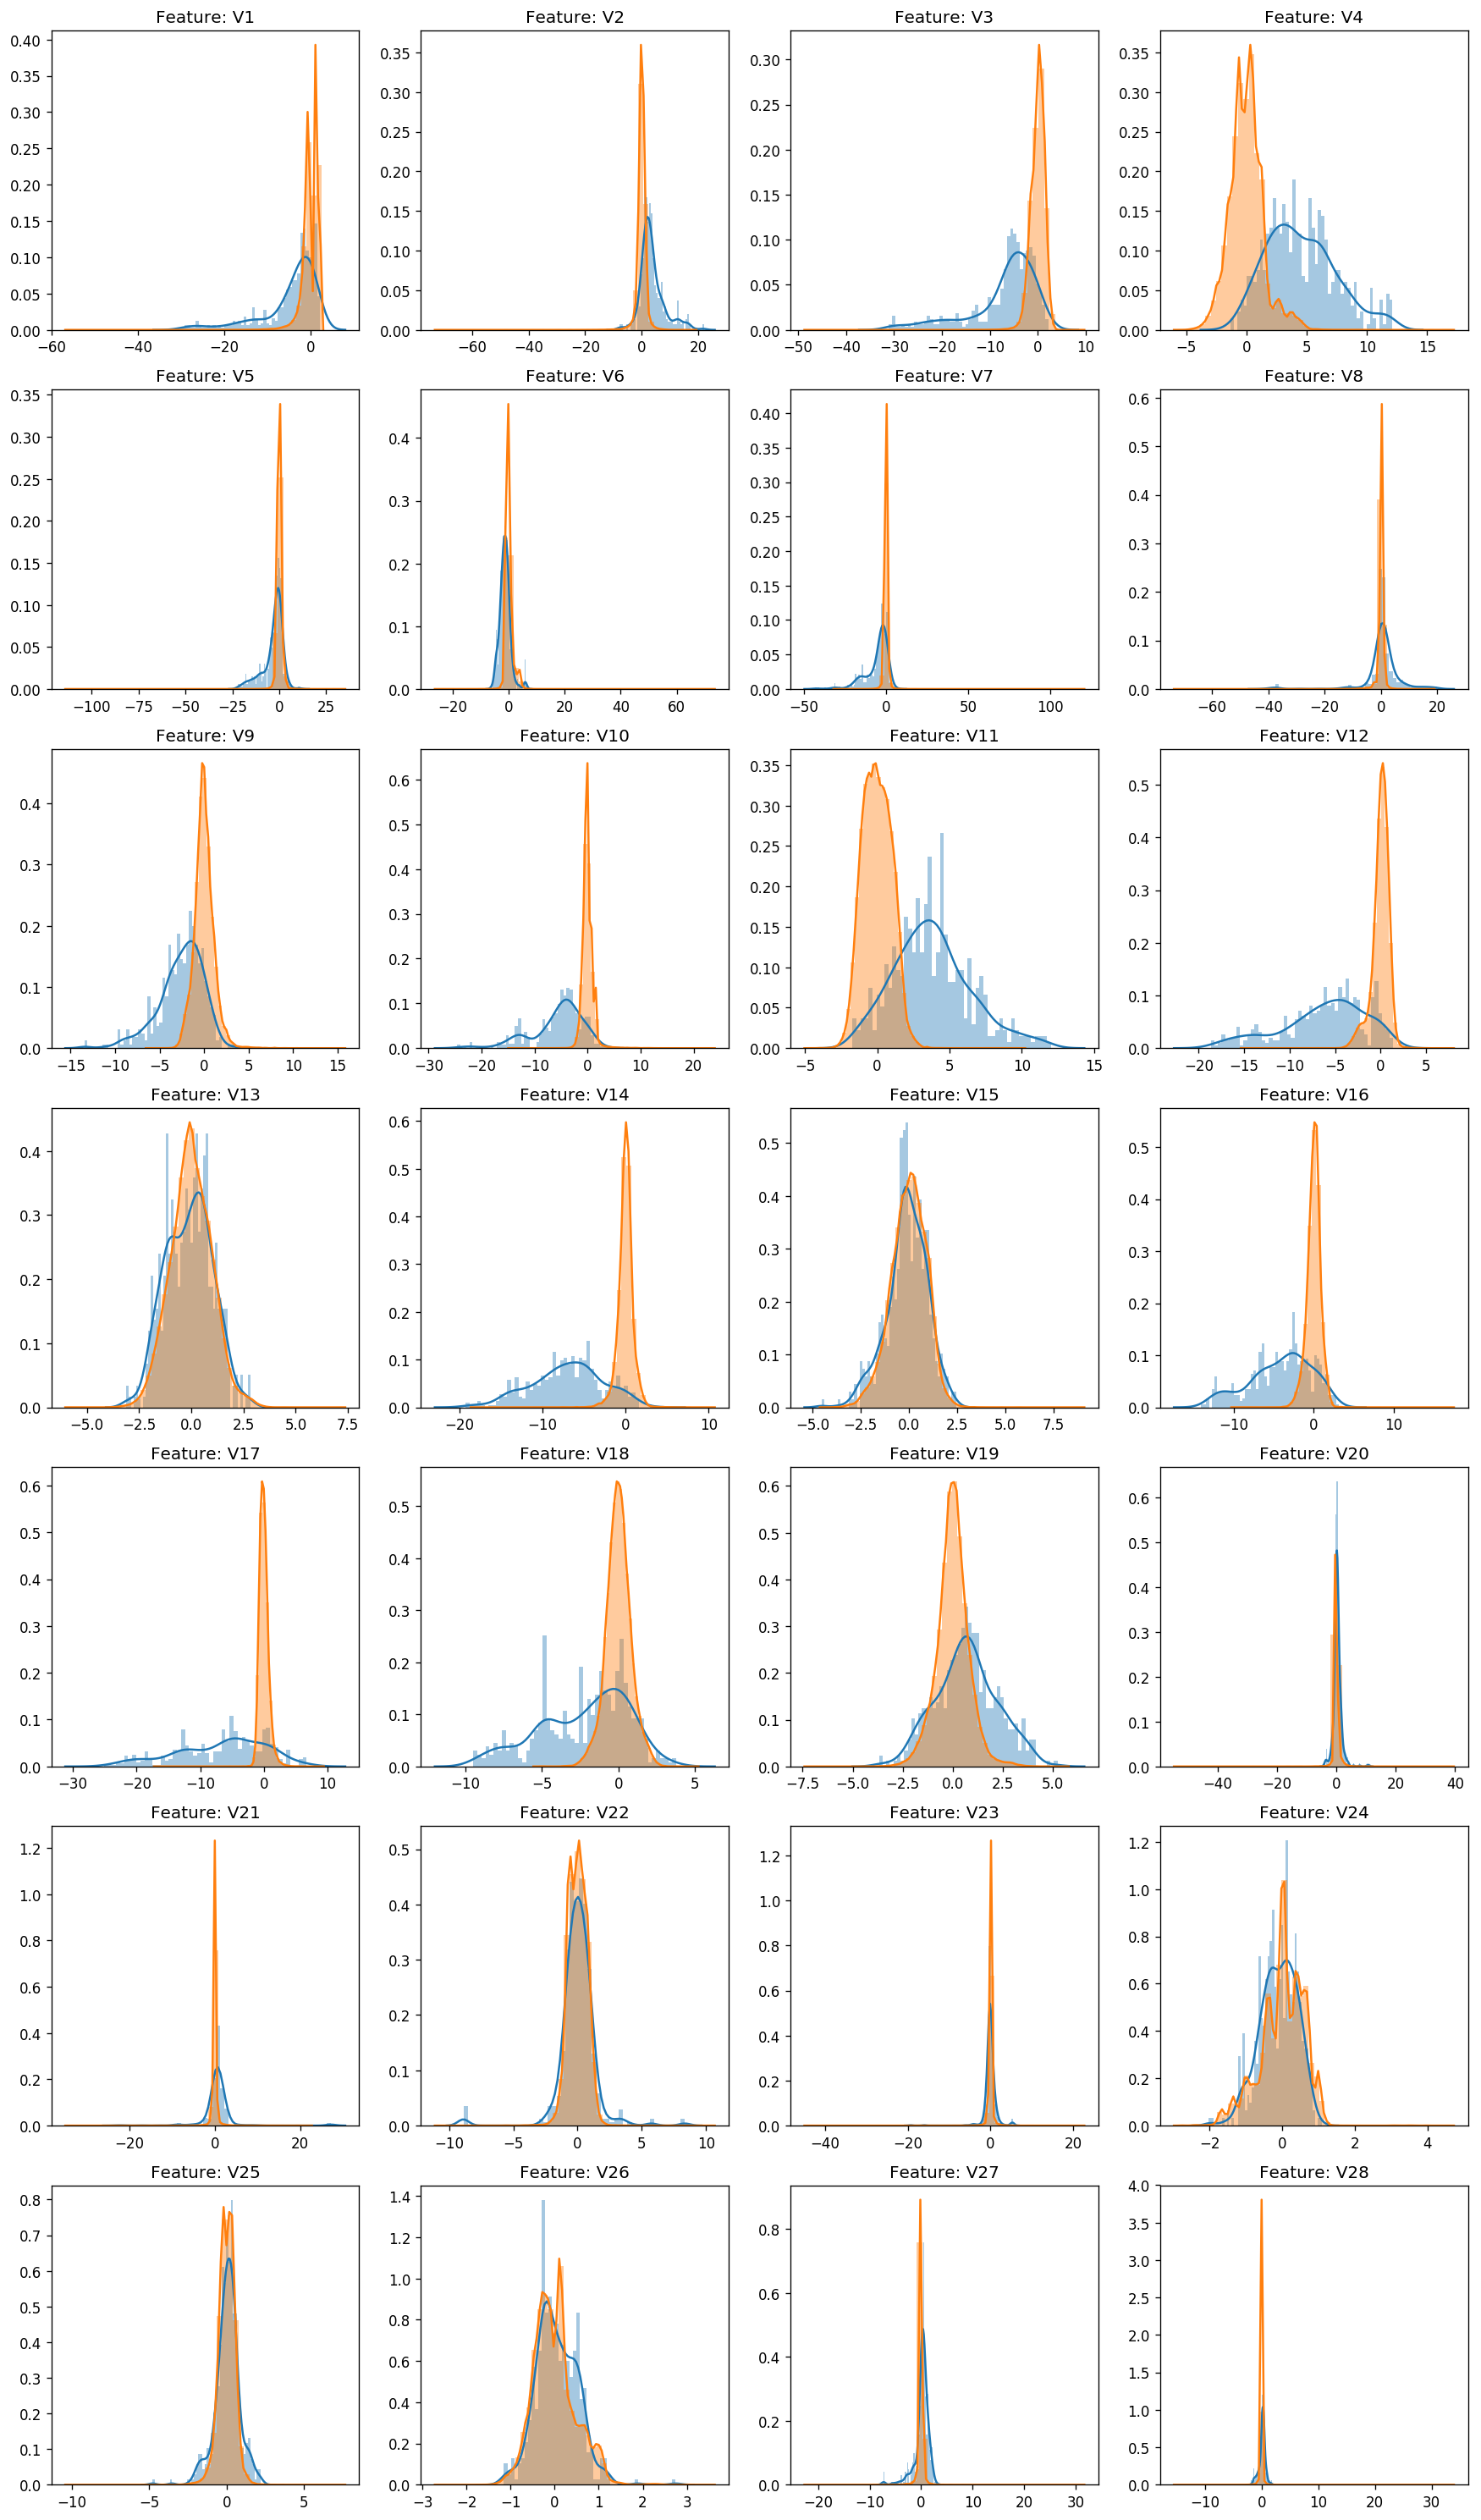

In [6]:
plt.figure(figsize=(18, 8*4), dpi=120)
gs = gridspec.GridSpec(7, 4)
v_features = transactions.iloc[:,1:29].columns
for i, cn in enumerate(transactions[v_features]):
    ax = plt.subplot(gs[i])
    sns.distplot(transactions[cn][transactions['Class'] == FRAUD_TRANSACTION], bins=50)
    sns.distplot(transactions[cn][transactions['Class'] == REGULAR_TRANSACTION], bins=50)
    ax.set_xlabel('')
    ax.set_title('Feature: ' + str(cn))
plt.show()

As you can see, some of these features show very well that fraud transactions differ from regular transactions. We can only guess what these features describe. In the real life we would probably know what stands behind these magic symbols :)

## 3. Prepare dataset

Now, let's prepare our dataset for analysis. We cannot use all of our features. Well, we could but it doesn't mean that it will be beneficial for the model. Feel free to check it if you want :)

In [7]:
INTERESTING_FEATURES = ['V3', 'V4', 'V7', 'V9', 'V10', 'V11', 'V12', 'V14', 'V16', 'V17', 'V18']

Now, let's split all transactions into two groups - fraud and regular ones. Also, let's leave only these features that are interesting.

In [8]:
fraud_transactions = transactions[transactions['Class'] == FRAUD_TRANSACTION]
fraud_transactions = fraud_transactions[INTERESTING_FEATURES]
fraud_transactions.head()

,V3,V4,V7,V9,V10,V11,V12,V14,V16,V17,V18
541,-1.609851,3.997906,-2.537387,-2.770089,-2.772272,3.202033,-2.899907,-4.289254,-1.140747,-2.830056,-0.016822
623,1.088463,2.288644,0.325574,-0.270953,-0.838587,-0.414575,-0.503141,-1.692029,0.666780,0.599717,1.725321
4920,-0.359745,2.330243,0.562320,-0.238253,-1.525412,2.032912,-6.560124,-1.470102,-2.282194,-4.781831,-2.615665
6108,-2.592844,2.679787,-3.496197,-0.247768,-4.801637,4.895844,-10.912819,-6.771097,-7.358083,-12.598419,-5.131549
6329,-4.304597,4.732795,1.713445,-1.282858,-2.447469,2.101344,-4.609628,-6.079337,2.581851,6.739384,3.042493


In [9]:
regular_transactions = transactions[transactions['Class'] == REGULAR_TRANSACTION]
regular_transactions = regular_transactions[INTERESTING_FEATURES]
regular_transactions.head()

,V3,V4,V7,V9,V10,V11,V12,V14,V16,V17,V18
0,2.536347,1.378155,0.239599,0.363787,0.090794,-0.551600,-0.617801,-0.311169,-0.470401,0.207971,0.025791
1,0.166480,0.448154,-0.078803,-0.255425,-0.166974,1.612727,1.065235,-0.143772,0.463917,-0.114805,-0.183361
2,1.773209,0.379780,0.791461,-1.514654,0.207643,0.624501,0.066084,-0.165946,-2.890083,1.109969,-0.121359
3,1.792993,-0.863291,0.237609,-1.387024,-0.054952,-0.226487,0.178228,-0.287924,-1.059647,-0.684093,1.965775
4,1.548718,0.403034,0.592941,0.817739,0.753074,-0.822843,0.538196,-1.119670,-0.451449,-0.237033,-0.038195


Also, we don't need all of these features anymore, so let's leave only interesting one in `transactions` DataFrame.

In [10]:
transactions = transactions[INTERESTING_FEATURES]

## 4. Let's use our model!

Again, we will use Scikit Learn implementation for the algorithm. This time we will use `GaussianMixture` class which supports `n_components` parameter. For now, we will use only 1 Gaussian component but feel free to change it later and see if it will improve our accuracy or not.

In [11]:
model = GaussianMixture(n_components=1)
model.fit(regular_transactions)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=1, n_init=1, precisions_init=None,
        random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

Fitted model has two internal properties that are specific to this algorithm - `means_` for mean values and `covariances_` for matricies of covariances.

In [12]:
model.means_.shape

(1, 11)

In [13]:
model.covariances_.shape

(1, 11, 11)

## 5. Check scores for each Transaction

Now, let's look what our model is capable of. At the beginning, let's score our transactions using `score_samples` method.

In [14]:
transactions_scores = model.score_samples(transactions.values)
transactions_scores

array([-12.5472515 , -12.07843873, -18.45902071, ..., -13.77478227,
       -14.36130187, -12.33423261])

We received one score for each example in our dataset. This is value returned by Probability Density Function (PDF) for all of models' Gaussians.

Let's check some basic statistics like `min` and `max` values.

In [16]:
transactions_scores.min(), transactions_scores.max()

(-5938.9558916132055, -10.255449414470327)

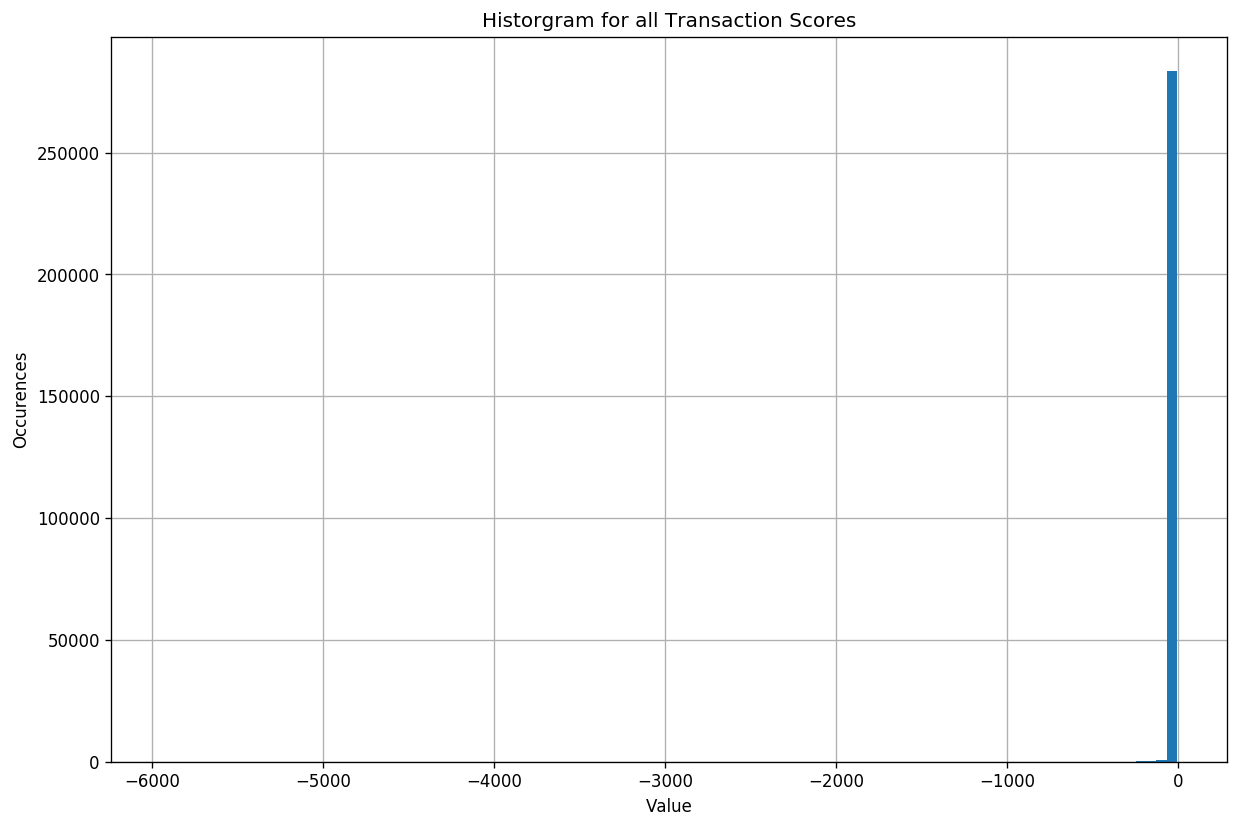

In [20]:
plt.figure(figsize=(12, 8), dpi=120)
ax = plt.subplot(1, 1, 1)
ax.set_axisbelow(True)
plt.grid()
plt.hist(transactions_scores, bins=100)
plt.title('Historgram for all Transaction Scores')
plt.xlabel('Value')
plt.ylabel('Occurences')
plt.show()

Above chart is unreadable... Let's check it also in the logarithmic scale.

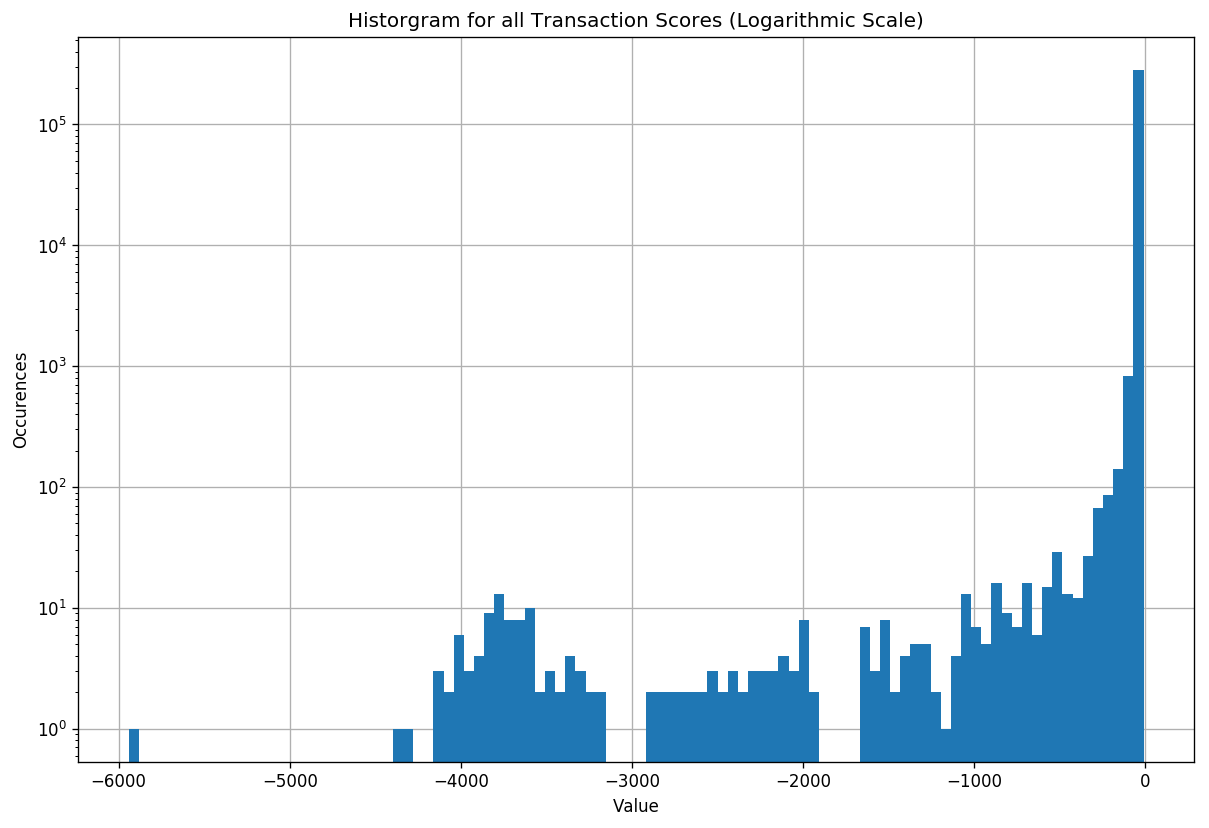

In [21]:
plt.figure(figsize=(12, 8), dpi=120)
ax = plt.subplot(1, 1, 1)
ax.set_axisbelow(True)
plt.grid()
plt.hist(transactions_scores, bins=100)
plt.yscale('log', nonposy='clip')
plt.title('Historgram for all Transaction Scores (Logarithmic Scale)')
plt.xlabel('Value')
plt.ylabel('Occurences')
plt.show()

Ahhh... Much better :)

## 6. Find the best threshold (epsilon)

**Before you go further!** You need to understand what Precission, Recall and F1 Score are :)

 - **Precision** tell us how many selected items are relevant.
 - **Recall** tell us how many relevant items are selected.
 - **F1 Score** is the harmonic mean of precision and recall.

![Precision and Recall](assets/precision_recall.png)

To detect anomalies, we need to find a threshold that will separate all fraud transactions from regular one. It won't be perfect but we need to place some barrier somewhere. To find the best value, simply simulate as many thresholds as possible and select the best one :)

In [26]:
thresholds = range(int(transactions_scores.min()), int(transactions_scores.max()), 1)
precisions, recalls, f1_scores = [], [], []

for threshold in thresholds:
    fraud_positives = fraud_transactions_scores[fraud_transactions_scores < threshold].shape[0]
    fraud_negatives = fraud_transactions_scores[fraud_transactions_scores >= threshold].shape[0]
    regular_positives = regular_transactions_scores[regular_transactions_scores < threshold].shape[0]
    regular_negatives = regular_transactions_scores[regular_transactions_scores >= threshold].shape[0]
    
    try:
        precision = fraud_positives / (fraud_positives + regular_positives)
    except ZeroDivisionError:
        precision = 0
        
    try:
        recall = fraud_positives / (fraud_positives + fraud_negatives)
    except ZeroDivisionError:
        recall = 0
    
    try:
        f1_score = 2 * (precision * recall) / (precision + recall)
    except ZeroDivisionError:
        f1_score = 0
        
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1_score)

And visualize it on a graph that will be more readable. The first one will be **precision**.

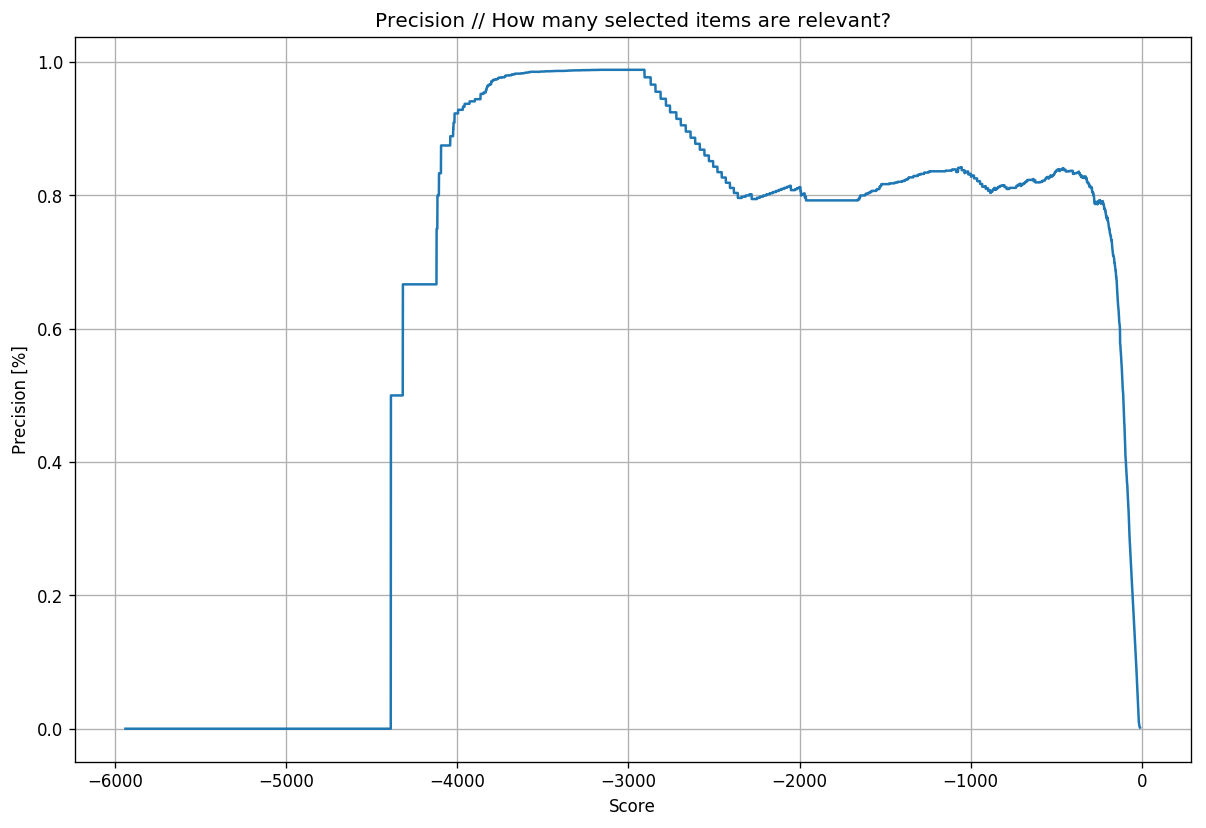

In [29]:
plt.figure(figsize=(12, 8), dpi=120)
ax = plt.subplot(1, 1, 1)
ax.set_axisbelow(True)
plt.grid()
plt.plot(thresholds, precisions)
plt.title('Precision // How many selected items are relevant?')
plt.xlabel('Value')
plt.ylabel('Precision [%]')
plt.show()

Now, let's plot **recall**.

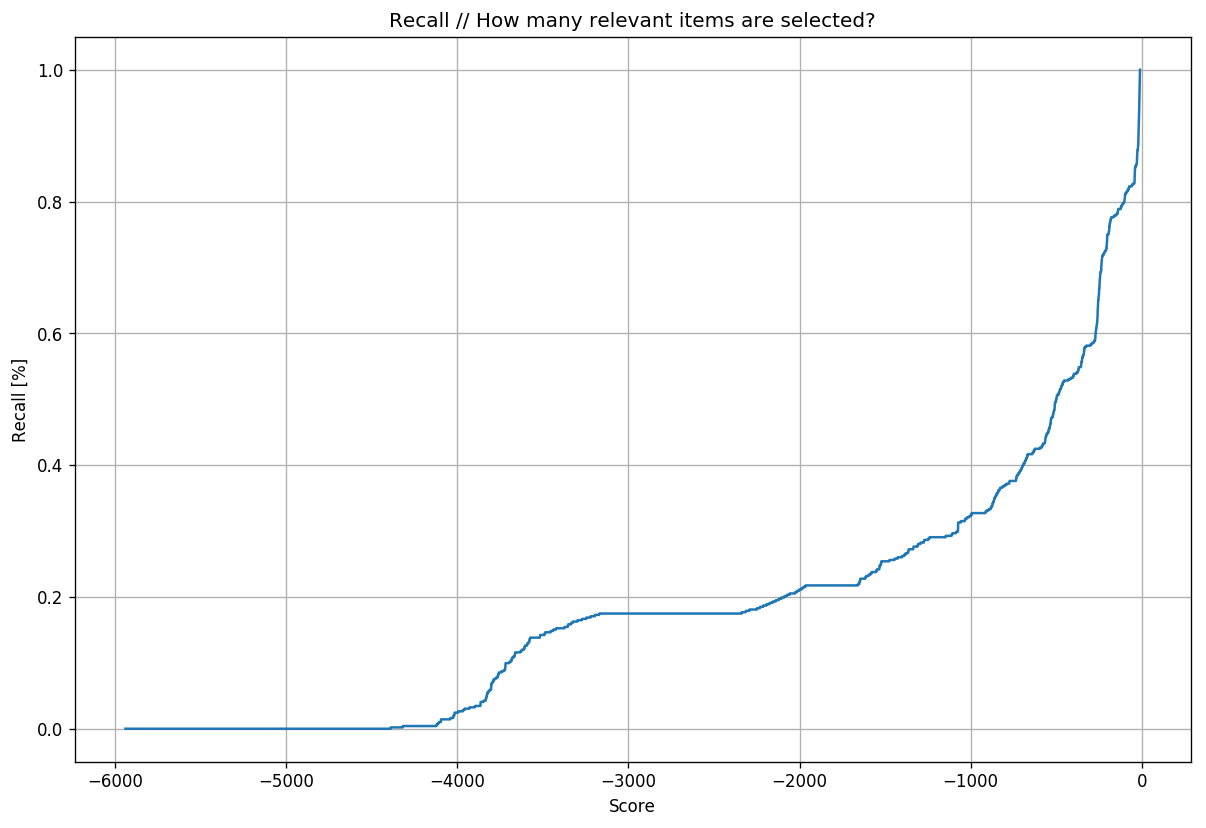

In [30]:
plt.figure(figsize=(12, 8), dpi=120)
ax = plt.subplot(1, 1, 1)
ax.set_axisbelow(True)
plt.grid()
plt.plot(thresholds, recalls)
plt.title('Recall // How many relevant items are selected?')
plt.xlabel('Value')
plt.ylabel('Recall [%]')
plt.show()

...and **F1 Score** :)

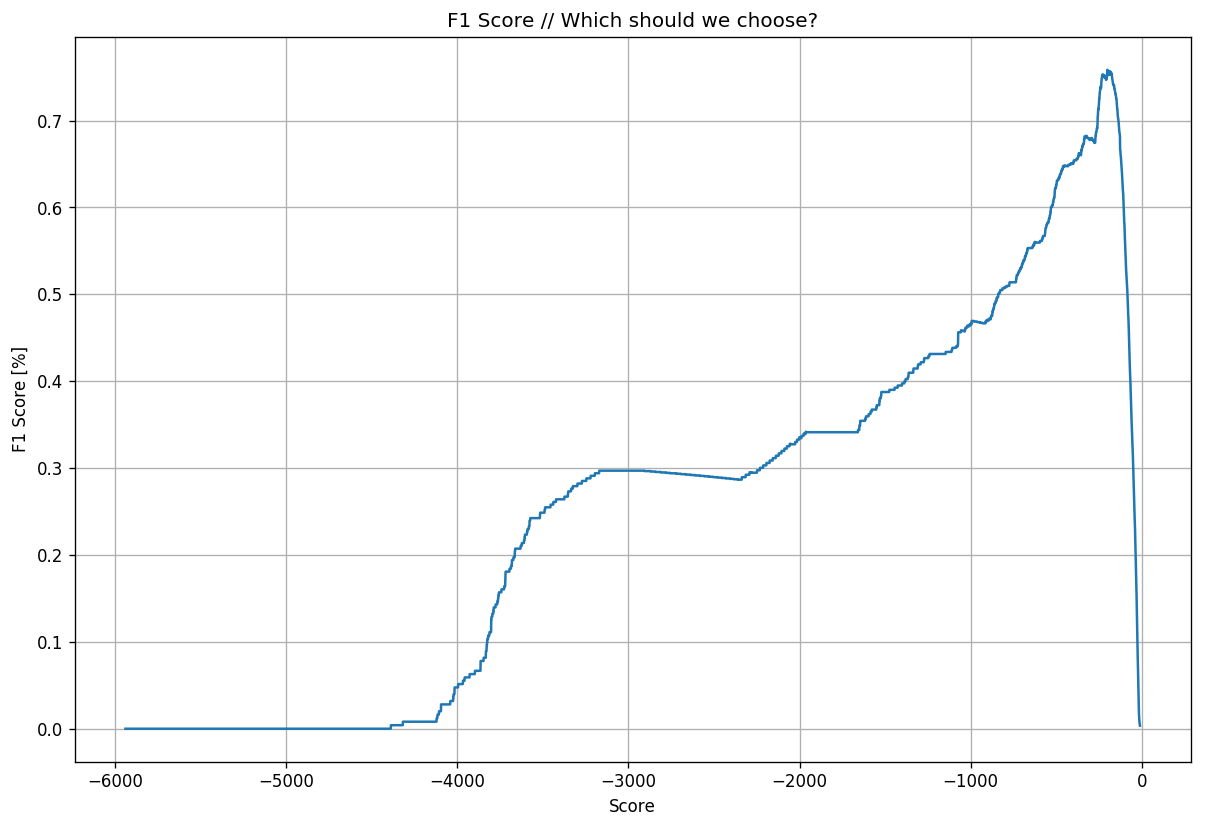

In [31]:
plt.figure(figsize=(12, 8), dpi=120)
ax = plt.subplot(1, 1, 1)
ax.set_axisbelow(True)
plt.grid()
plt.plot(thresholds, f1_scores)
plt.title('F1 Score // Which should we choose?')
plt.xlabel('Value')
plt.ylabel('F1 Score [%]')
plt.show()

F1 Score combines both the precission and recall, so it will be best baseline for score value threshold selection. As you might guess, we are looking for such value that maximizes the F1 Score. Let's do it in our code :)

In [32]:
best_threshold_idx = np.argmax(f1_scores)
THRESHOLD = thresholds[best_threshold_idx]
THRESHOLD

-202

## 7. How good is our model?

Once we know which threshold works best, let's check our accuracy on both fraud and regular transactions.

In [33]:
fraud_positives = fraud_transactions_scores[fraud_transactions_scores < THRESHOLD].shape[0]
fraud_negatives = fraud_transactions_scores[fraud_transactions_scores >= THRESHOLD].shape[0]
print('Fraud Examples:')
print(' - Positives: {} ({:.3f}%)'.format(fraud_positives, 100.0 * fraud_positives / len(fraud_transactions_scores)))
print(' - Negatives: {} ({:.3f}%)'.format(fraud_negatives, 100.0 * fraud_negatives / len(fraud_transactions_scores)))

Fraud Examples:
 - Positives: 369 (75.000%)
 - Negatives: 123 (25.000%)


In [34]:
regular_positives = regular_transactions_scores[regular_transactions_scores < THRESHOLD].shape[0]
regular_negatives = regular_transactions_scores[regular_transactions_scores >= THRESHOLD].shape[0]
print('Regular Examples:')
print(' - Positives: {} ({:.3f}%)'.format(regular_positives, 100.0 * regular_positives / len(regular_transactions_scores)))
print(' - Negatives: {} ({:.3f}%)'.format(regular_negatives, 100.0 * regular_negatives / len(regular_transactions_scores)))

Regular Examples:
 - Positives: 112 (0.039%)
 - Negatives: 284203 (99.961%)


In [35]:
precision = fraud_positives / (fraud_positives + regular_positives)
recall = fraud_positives / (fraud_positives + fraud_negatives)
f1_score = 2 * (precision * recall) / (precision + recall)
print('Precision: {:.3f}%'.format(precision * 100))
print('Recall: {:.3f}%'.format(recall * 100))
print('F1 Score: {:.3f}%'.format(f1_score * 100))

Precision: 76.715%
Recall: 75.000%
F1 Score: 75.848%
